In [9]:
RESULTS_DIR = "all-24-11-02-17-51-22"

# INIT

/tmp/ipykernel_96919/3806206560.py:68: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


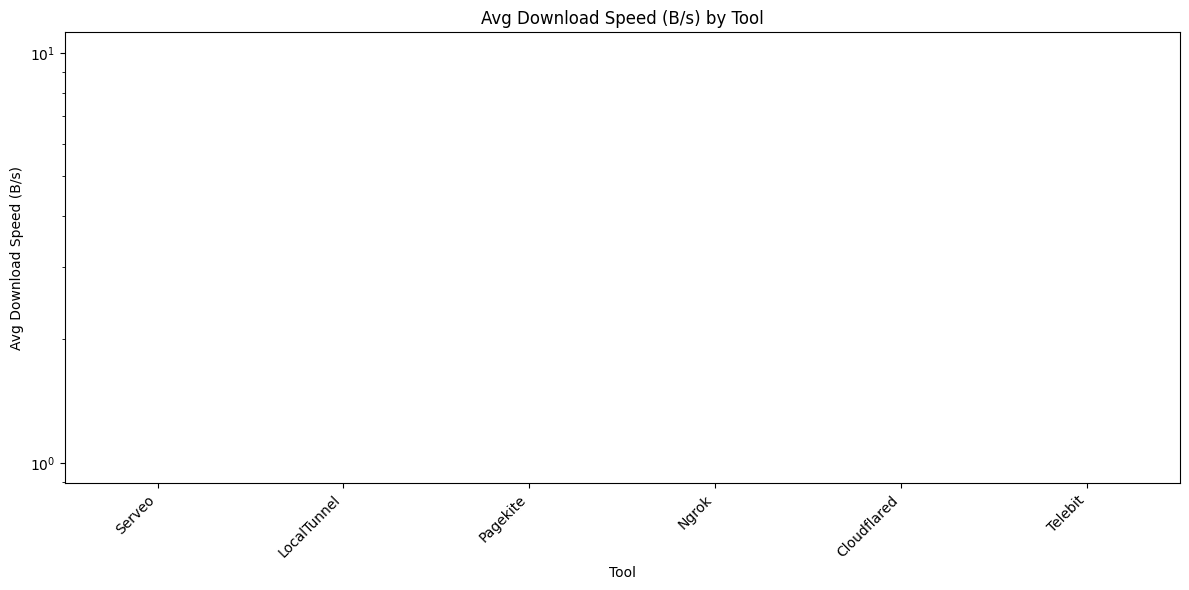

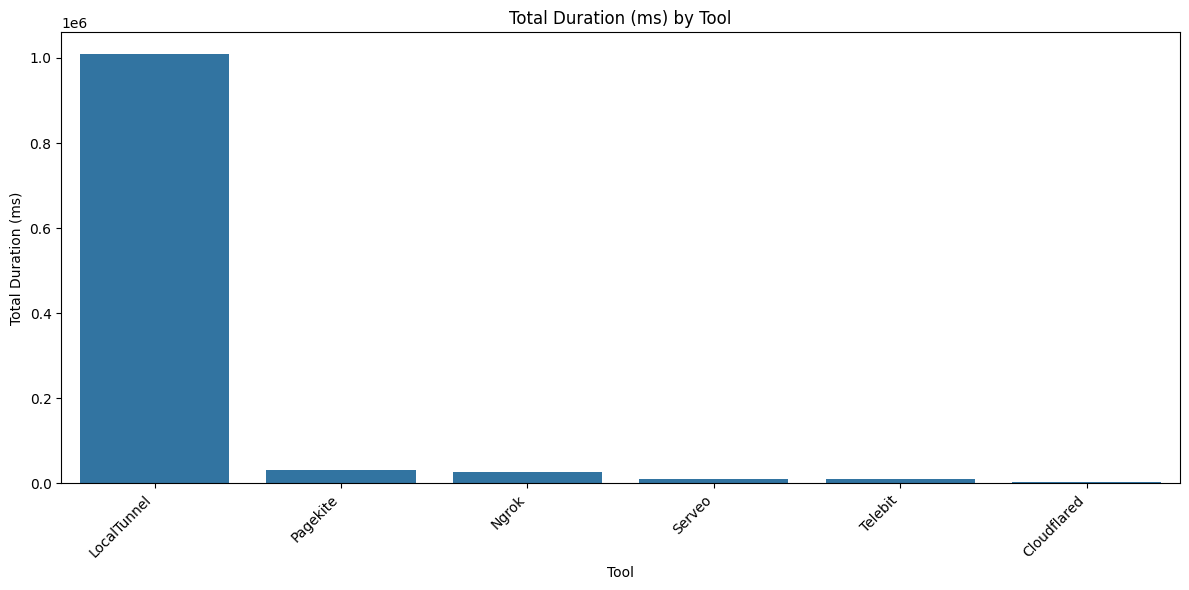

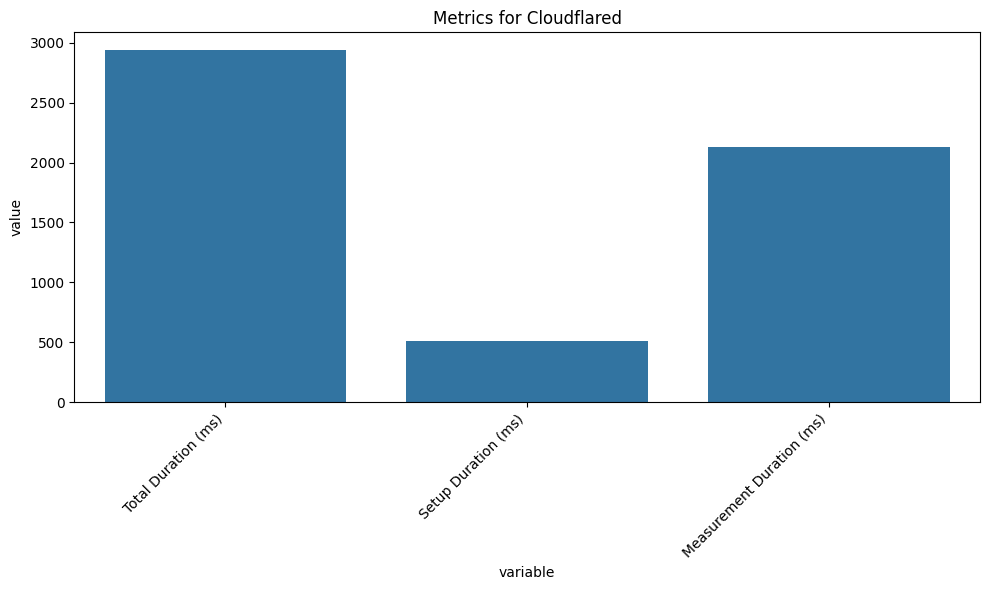

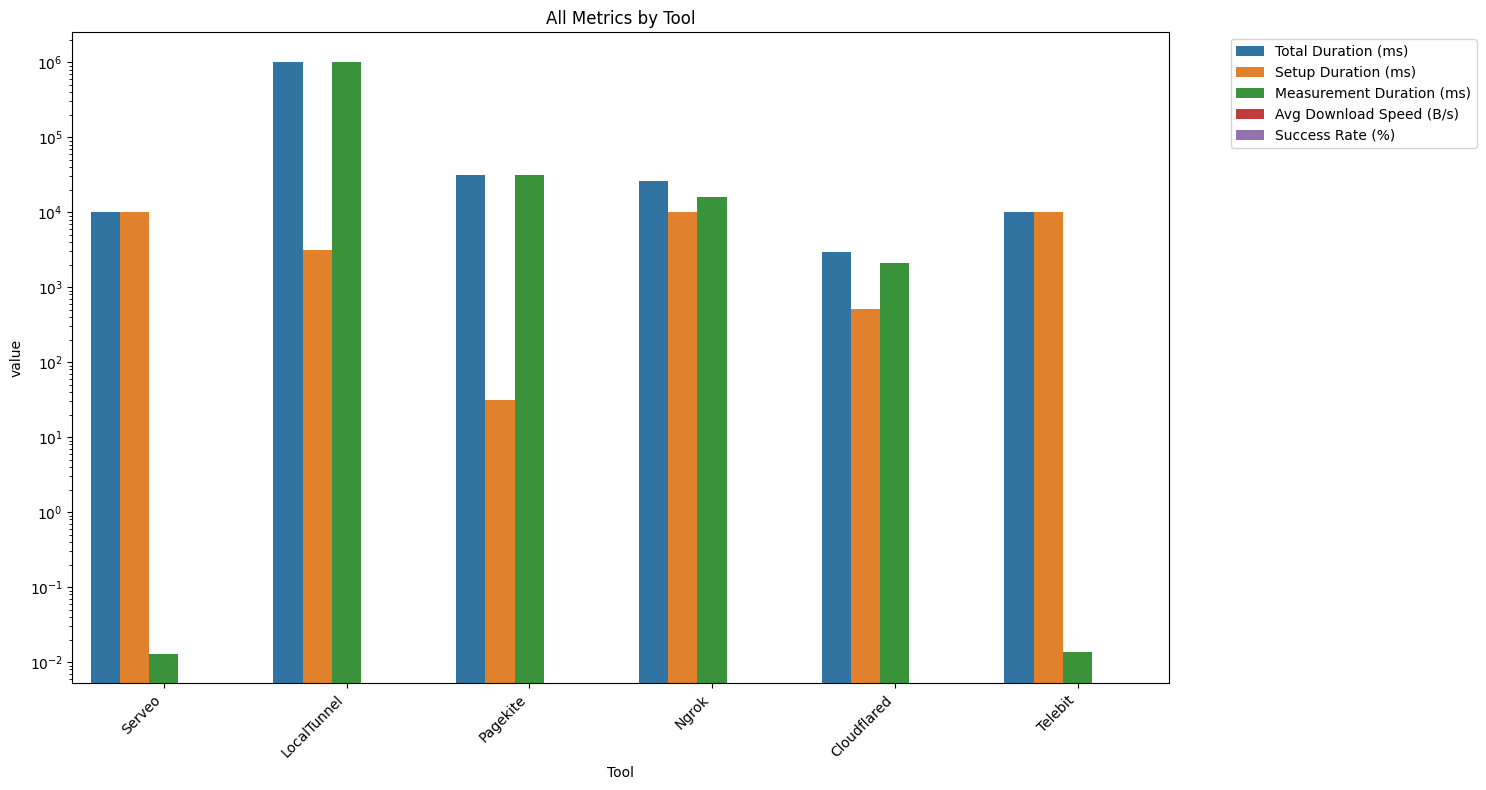

In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def process_json_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    tool_name = os.path.splitext(os.path.basename(file_path))[0]
    
    durations = data['durations']
    total_duration = durations['total']['duration']
    setup_duration = durations['toolSetup']['duration']
    measurement_duration = durations['measurements']['total']['duration']
    
    measurements = data['measurements']
    speeds = []
    successful_transfers = 0
    total_transfers = 0
    
    for m in measurements:
        for size in ['1MB', '2MB', '3MB']:
            buffer_key = f'{size}_buffer'
            if buffer_key in m['fileTransfers']:
                transfer = m['fileTransfers'][buffer_key]
                total_transfers += 1
                
                if (transfer['downloadStatus'] == 'complete' and 
                    transfer['statusCode'] == 200):
                    speeds.append(transfer['speedDownload'])
                    successful_transfers += 1
    
    avg_speed = sum(speeds) / len(speeds) if speeds else 0
    success_rate = (successful_transfers / total_transfers * 100) if total_transfers else 0
    
    return {
        'Tool': tool_name,
        'Total Duration (ms)': total_duration,
        'Setup Duration (ms)': setup_duration,
        'Measurement Duration (ms)': measurement_duration,
        'Avg Download Speed (B/s)': avg_speed,
        'Success Rate (%)': success_rate
    }

def process_directory(directory):
    results = []
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            results.append(process_json_file(file_path))
    return pd.DataFrame(results)

def plot_metric(df, metric, scale='linear', plot_type='bar'):
    """Plot a single metric across all tools"""
    plt.figure(figsize=(12, 6))
    
    if plot_type == 'bar':
        sns.barplot(data=df.sort_values(metric, ascending=False), 
                   x='Tool', y=metric)
    elif plot_type == 'box':
        sns.boxplot(data=df.sort_values(metric, ascending=False), 
                   x='Tool', y=metric)
    
    plt.xticks(rotation=45, ha='right')
    if scale == 'log':
        plt.yscale('log')
    
    plt.title(f'{metric} by Tool')
    plt.tight_layout()
    return plt.gcf()

def plot_tool_metrics(df, tool_name, scale='linear', ignore_metrics=["Avg Download Speed (B/s)", "Success Rate (%)" ]):
    """Plot all metrics for a single tool, with an option to ignore certain metrics"""
    if ignore_metrics is None:
        ignore_metrics = []
    
    metrics = [col for col in df.columns if col != 'Tool' and col not in ignore_metrics]
    tool_data = df[df['Tool'] == tool_name][['Tool'] + metrics].melt(id_vars=['Tool'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=tool_data, x='variable', y='value')
    plt.xticks(rotation=45, ha='right')
    
    if scale == 'log':
        plt.yscale('log')
    
    plt.title(f'Metrics for {tool_name}')
    plt.tight_layout()
    return plt.gcf()

def plot_all_metrics(df, scale='linear'):
    """Plot all metrics for all tools"""
    metrics = [col for col in df.columns if col != 'Tool']
    melted_data = df.melt(id_vars=['Tool'])
    
    plt.figure(figsize=(15, 8))
    sns.barplot(data=melted_data, x='Tool', y='value', hue='variable')
    plt.xticks(rotation=45, ha='right')
    
    if scale == 'log':
        plt.yscale('log')
    
    plt.title('All Metrics by Tool')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return plt.gcf()

# Example usage:
directory = RESULTS_DIR
df = process_directory(directory)

# Plot single metric (linear scale)
fig1 = plot_metric(df, 'Avg Download Speed (B/s)', scale='log')

# Plot single metric (log scale)
fig2 = plot_metric(df, 'Total Duration (ms)', scale='linear')

# Plot all metrics for one tool
fig3 = plot_tool_metrics(df, 'Cloudflared', scale='linear')

# Plot all metrics together
fig4 = plot_all_metrics(df, scale='log')

plt.show()

# File transfers

In [21]:
import os
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import List, Dict, Optional

class TunnelAnalyzer:
    def __init__(self, directory: str):
        self.raw_data = self._load_data(directory)
        self.detailed_df = self._create_detailed_df()
        # Debug print to check DataFrame
        print("DataFrame columns:", self.detailed_df.columns)
        print("DataFrame shape:", self.detailed_df.shape)
    
    def _load_data(self, directory: str) -> Dict:
        data = {}
        for filename in os.listdir(directory):
            if filename.endswith('.json'):
                tool_name = os.path.splitext(filename)[0]
                file_path = os.path.join(directory, filename)
                print(f"Loading {file_path}")  # Debug print
                with open(file_path, 'r') as f:
                    data[tool_name] = json.load(f)
        return data
    def _create_detailed_df(self) -> pd.DataFrame:
        records = []
        for tool, data_list in self.raw_data.items():
            print(f"Processing tool: {tool}")
            
            # Ensure data_list is a list
            measurements = data_list if isinstance(data_list, list) else [data_list]
            
            for measurement in measurements:
                if 'fileTransfers' not in measurement:
                    print(f"Warning: No fileTransfers in measurement {measurement.get('measurementNumber', 'unknown')} for {tool}")
                    continue
                
                for transfer in measurement['fileTransfers']:
                    try:
                        record = {
                            'Tool': tool,
                            'Measurement': measurement['measurementNumber'],
                            'Transfer Type': transfer['filename'],
                            'File Size (MB)': transfer['fileSize'] / (1024 * 1024),  # Convert to MB
                            'Status Code': transfer['statusCode'],
                            'Download Speed (MB/s)': transfer['downloadSpeed'] / 1_000_000,
                            'DNS Lookup (s)': transfer['dnsLookup'],
                            'TCP Connection (s)': transfer['tcpConnection'],
                            'TLS Handshake (s)': transfer['tlsHandshake'],
                            'TTFB (s)': transfer['timeToFirstByte'],
                            'Total Time (s)': transfer['totalTransferTime'],
                            'Success': transfer['transferSuccess'],
                            'Has Error': measurement.get('hasErrors', False),
                            'Hash Match': transfer.get('hashMatch', False),
                            'Size Match': transfer.get('sizeMatch', False)
                        }
                        records.append(record)
                    except Exception as e:
                        print(f"Error processing record for {tool}: {str(e)}")
        
        if not records:
            print("Warning: No records were processed!")
            return pd.DataFrame()
            
        df = pd.DataFrame(records)
        print(f"Created DataFrame with {len(df)} records")
        return df

    def plot_comparison(self, metric: str, plot_type: str = 'box', scale: str = 'linear',
                       filter_successful: bool = True) -> go.Figure:
        """
        Create a comparison plot for a specific metric
        """
        df = self.detailed_df
        print(f"Initial DataFrame shape: {df.shape}")  # Debug print
        
        if filter_successful:
            df = df[df['Success']]
            print(f"DataFrame shape after success filter: {df.shape}")  # Debug print

        # Check if we have data to plot
        if df.empty:
            print("Warning: No data to plot after filtering!")
            return go.Figure()  # Return empty figure

        print(f"Unique tools: {df['Tool'].unique()}")  # Debug print
        print(f"Value range for {metric}: {df[metric].min()} to {df[metric].max()}")  # Debug print

        fig = go.Figure()
        
        # Color coding based on errors
        colors = df['Has Error'].map({True: 'rgba(255,0,0,0.6)', False: 'rgba(0,128,0,0.6)'})
        
        try:
            if plot_type == 'box':
                for tool in df['Tool'].unique():
                    tool_data = df[df['Tool'] == tool]
                    print(f"Adding box plot for {tool} with {len(tool_data)} points")  # Debug print
                    fig.add_trace(go.Box(
                        x=[tool] * len(tool_data),
                        y=tool_data[metric],
                        name=tool,
                        boxpoints='all',
                        jitter=0.3,
                        pointpos=-1.8,
                        marker_color=colors[tool_data.index]
                    ))
            elif plot_type == 'violin':
                for tool in df['Tool'].unique():
                    tool_data = df[df['Tool'] == tool]
                    fig.add_trace(go.Violin(
                        x=[tool] * len(tool_data),
                        y=tool_data[metric],
                        name=tool,
                        box_visible=True,
                        meanline_visible=True,
                        fillcolor=colors[tool_data.index].iloc[0]
                    ))
            elif plot_type == 'bar':
                grouped = df.groupby(['Tool', 'Has Error'])[metric].agg(['mean', 'std']).reset_index()
                for _, row in grouped.iterrows():
                    fig.add_trace(go.Bar(
                        x=[row['Tool']],
                        y=[row['mean']],
                        error_y=dict(type='data', array=[row['std']]),
                        name=f"{row['Tool']} {'(with errors)' if row['Has Error'] else ''}",
                        marker_color='rgba(255,0,0,0.6)' if row['Has Error'] else 'rgba(0,128,0,0.6)'
                    ))
        except Exception as e:
            print(f"Error during plotting: {str(e)}")
            return go.Figure()  # Return empty figure on error

        return fig

    def plot_time_components(self, tool_filter: Optional[List[str]] = None) -> go.Figure:
        """Plot breakdown of time components for selected tools"""
        df = self.detailed_df
        if tool_filter:
            df = df[df['Tool'].isin(tool_filter)]
            
        time_components = ['DNS Lookup (s)', 'TCP Connection (s)', 
                          'TLS Handshake (s)', 'TTFB (s)']
        
        fig = go.Figure()
        
        # Create stacked bars for each tool, colored by error status
        for tool in df['Tool'].unique():
            tool_data = df[df['Tool'] == tool]
            color = 'rgba(255,0,0,0.6)' if tool_data['Has Error'].any() else 'rgba(0,128,0,0.6)'
            
            for component in time_components:
                fig.add_trace(go.Bar(
                    name=component,
                    x=[tool],
                    y=[tool_data[component].mean()],
                    marker_color=color,
                    opacity=0.7
                ))
            
        fig.update_layout(
            barmode='stack',
            title="Connection Time Components by Tool",
            yaxis_title="Time (seconds)",
            showlegend=True
        )
        
        return fig

    def plot_performance_dashboard(self) -> go.Figure:
        """Creates a comprehensive performance dashboard"""
        print("Creating performance dashboard...")  # Debug print
        
        if self.detailed_df.empty:
            print("Warning: DataFrame is empty!")
            return go.Figure()

        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Download Speed Distribution',
                'Success Rate by File Size',
                'Time Components',
                'Error Analysis'
            )
        )

        try:
            # Download Speed Distribution (Violin Plot)
            print("Adding download speed distribution...")  # Debug print
            for tool in self.detailed_df['Tool'].unique():
                tool_data = self.detailed_df[self.detailed_df['Tool'] == tool]
                print(f"Processing {tool} with {len(tool_data)} records")  # Debug print
                fig.add_trace(
                    go.Violin(
                        x=[tool] * len(tool_data),
                        y=tool_data['Download Speed (MB/s)'],
                        name=tool,
                        box_visible=True,
                        meanline_visible=True,
                        showlegend=False
                    ),
                    row=1, col=1
                )

            # Success Rate by File Size
            success_rate = self.detailed_df.groupby(['Tool', 'File Size (MB)'])['Success'].mean() * 100
            success_df = success_rate.reset_index()
            fig.add_trace(
                go.Bar(
                    x=success_df['Tool'],
                    y=success_df['Success'],
                    name='Success Rate',
                    marker_color='rgba(0,128,0,0.6)'
                ),
                row=1, col=2
            )

            # Time Components
            time_components = ['DNS Lookup (s)', 'TCP Connection (s)', 
                              'TLS Handshake (s)', 'TTFB (s)']
            avg_times = self.detailed_df.groupby('Tool')[time_components].mean()
            
            for component in time_components:
                fig.add_trace(
                    go.Bar(
                        name=component,
                        x=avg_times.index,
                        y=avg_times[component],
                        showlegend=True
                    ),
                    row=2, col=1
                )

            # Error Analysis
            error_counts = self.detailed_df.groupby('Tool')['Has Error'].sum()
            fig.add_trace(
                go.Bar(
                    x=error_counts.index,
                    y=error_counts.values,
                    name='Errors',
                    marker_color='rgba(255,0,0,0.6)'
                ),
                row=2, col=2
            )
        except Exception as e:
            print(f"Error creating dashboard: {str(e)}")
            return go.Figure()  # Return empty figure on error

        fig.update_layout(
            height=800,
            showlegend=True,
            title_text="Tunnel Performance Analysis Dashboard",
            barmode='stack'
        )

        return fig

    def get_available_metrics(self) -> List[str]:
        """Return list of available metrics for plotting"""
        return [col for col in self.detailed_df.columns 
                if col not in ['Tool', 'Measurement', 'Filename', 'Success', 'Has Error']]

# Example usage with debug output:
if __name__ == "__main__":
    print(f"Analyzing results in: {RESULTS_DIR}")
    
    analyzer = TunnelAnalyzer(RESULTS_DIR)
    
    if analyzer.detailed_df.empty:
        print("Error: No data was loaded into the DataFrame")
    else:
        # Get available metrics
        metrics = analyzer.get_available_metrics()
        print("Available metrics:", metrics)
        
        # Create and show the performance dashboard
        dashboard = analyzer.plot_performance_dashboard()
        dashboard.show()

        # Create specific plots
        speed_plot = analyzer.plot_comparison(
            metric='Download Speed (MB/s)',
            plot_type='violin',
            scale='log',
            filter_successful=False
        )
        speed_plot.show()

        time_plot = analyzer.plot_time_components()
        time_plot.show()

Analyzing results in: all-24-11-02-17-51-22
Loading all-24-11-02-17-51-22/Serveo.json
Loading all-24-11-02-17-51-22/LocalTunnel.json
Loading all-24-11-02-17-51-22/Pagekite.json
Loading all-24-11-02-17-51-22/Ngrok.json
Loading all-24-11-02-17-51-22/Cloudflared.json
Loading all-24-11-02-17-51-22/Telebit.json
Processing tool: Serveo
Processing tool: LocalTunnel
Processing tool: Pagekite
Processing tool: Ngrok
Processing tool: Cloudflared
Processing tool: Telebit
DataFrame columns: RangeIndex(start=0, stop=0, step=1)
DataFrame shape: (0, 0)
Error: No data was loaded into the DataFrame


In [28]:
class TunnelAnalyzer:
    def __init__(self, directory: str):
        self.raw_data = self._load_data(directory)
        self.detailed_df = self._create_detailed_df()
        
    def _load_data(self, directory: str) -> Dict:
        data = {}
        for filename in os.listdir(directory):
            if filename.endswith('.json'):
                tool_name = os.path.splitext(filename)[0]
                with open(os.path.join(directory, filename), 'r') as f:
                    data[tool_name] = json.load(f)
        return data

    def _create_detailed_df(self) -> pd.DataFrame:
        records = []
        for tool, data_list in self.raw_data.items():
            # Ensure data_list is a list
            measurements = data_list if isinstance(data_list, list) else [data_list]
            
            for measurement in measurements:
                # Get measurement metadata
                tool_name = measurement.get('toolName', tool)  # Use filename if toolName not present
                measurement_num = measurement.get('measurementNumber', 0)
                
                # Process each file transfer
                for transfer in measurement.get('fileTransfers', []):
                    record = {
                        'Tool': tool_name,
                        'Measurement': measurement_num,
                        'Filename': transfer.get('filename', ''),
                        'File Size (MB)': transfer.get('fileSize', 0) / (1024 * 1024),
                        'Status Code': transfer.get('statusCode', -1),
                        'Download Speed (MB/s)': transfer.get('downloadSpeed', 0) / 1_000_000,
                        'Upload Speed (MB/s)': transfer.get('uploadSpeed', 0) / 1_000_000,
                        'DNS Lookup (s)': transfer.get('dnsLookup', 0),
                        'TCP Connection (s)': transfer.get('tcpConnection', 0),
                        'TLS Handshake (s)': transfer.get('tlsHandshake', 0),
                        'TTFB (s)': transfer.get('timeToFirstByte', 0),
                        'Total Time (s)': transfer.get('totalTransferTime', 0),
                        'Success': transfer.get('transferSuccess', False),
                        'Hash Match': transfer.get('hashMatch', False),
                        'Size Match': transfer.get('sizeMatch', False),
                        'Setup Time (s)': measurement.get('setupDuration', 0) / 1000,  # Convert ms to s
                        'Total Duration (s)': measurement.get('totalDuration', 0) / 1000,
                        'Has Errors': measurement.get('hasErrors', False)
                    }
                    records.append(record)
                    
        df = pd.DataFrame(records)
        if df.empty:
            print("Warning: No records were processed!")
        else:
            print(f"Processed {len(df)} records across {df['Tool'].nunique()} tools")
        return df

    def get_tool_stats(self, tool_name: Optional[str] = None) -> pd.DataFrame:
        """Get detailed statistics for one or all tools"""
        df = self.detailed_df
        if tool_name:
            df = df[df['Tool'] == tool_name]
            
        stats = df.groupby('toolName').agg({
            'Download Speed (MB/s)': ['mean', 'std', 'min', 'max', 'count'],
            'Total Time (s)': ['mean', 'std', 'min', 'max'],
            'Success': 'mean',
            'Hash Match': 'mean',
            'Size Match': 'mean'
        }).round(3)
        
        # Flatten column names
        stats.columns = [f"{col[0]}_{col[1]}" for col in stats.columns]
        return stats

    def plot_comparison(self, metric: str, plot_type: str = 'violin', 
                       scale: str = 'linear', filter_successful: bool = True) -> go.Figure:
        """Create a comparison plot for a specific metric"""
        df = self.detailed_df
        if filter_successful:
            df = df[df['Success']]

        fig = go.Figure()
        
        if plot_type == 'violin':
            for tool in df['Tool'].unique():
                tool_data = df[df['Tool'] == tool]
                fig.add_trace(go.Violin(
                    x=[tool] * len(tool_data),
                    y=tool_data[metric],
                    name=tool,
                    box_visible=True,
                    meanline_visible=True
                ))
        elif plot_type == 'box':
            fig.add_trace(go.Box(
                x=df['Tool'],
                y=df[metric],
                boxpoints='all',
                jitter=0.3,
                pointpos=-1.8
            ))

        fig.update_layout(
            title=f"{metric} by Tool",
            yaxis_title=metric,
            yaxis_type=scale,
            showlegend=(plot_type == 'violin')
        )
        
        return fig

    def plot_time_components(self, tool_name: Optional[str] = None) -> go.Figure:
        """Plot breakdown of time components for a specific tool or all tools"""
        df = self.detailed_df
        if tool_name:
            df = df[df['toolName'] == tool_name]
            
        time_components = ['DNS Lookup (s)', 'TCP Connection (s)', 
                          'TLS Handshake (s)', 'TTFB (s)']
        
        # Calculate means for each component
        means = df.groupby('toolName')[time_components].mean()
        
        fig = go.Figure()
        for component in time_components:
            fig.add_trace(go.Bar(
                name=component,
                x=means.index,
                y=means[component]
            ))
            
        fig.update_layout(
            barmode='stack',
            title=f"Connection Time Components{' for ' + tool_name if tool_name else ''}",
            yaxis_title="Time (seconds)"
        )
        
        return fig

# Example usage:
analyzer = TunnelAnalyzer(RESULTS_DIR)

# Get overall statistics
print("\nOverall Statistics:")
print(analyzer.get_tool_stats())

# Get statistics for a specific tool
print("\nNgrok Statistics:")
print(analyzer.get_tool_stats('Ngrok'))

# Plot comparisons
speed_plot = analyzer.plot_comparison(
    metric='Download Speed (MB/s)',
    plot_type='violin',
    scale='log'
)
speed_plot.show()

# Plot time components
time_plot = analyzer.plot_time_components()
time_plot.show()


Overall Statistics:


KeyError: 'toolName'

# Elaborate

In [25]:
import os
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from typing import List, Dict, Optional

class TunnelAnalyzer:
    def __init__(self, directory: str):
        self.raw_data = self._load_data(directory)
        self.summary_df = self._create_summary_df()
        self.detailed_df = self._create_detailed_df()
    
    def _load_data(self, directory: str) -> Dict:
        data = {}
        for filename in os.listdir(directory):
            if filename.endswith('.json'):
                tool_name = os.path.splitext(filename)[0]
                with open(os.path.join(directory, filename), 'r') as f:
                    data[tool_name] = json.load(f)
        return data

    def _create_detailed_df(self) -> pd.DataFrame:
        records = []
        for tool, data in self.raw_data.items():
            for measurement in data['measurements']:
                for transfer_type, transfer in measurement['fileTransfers'].items():
                    record = {
                        'Tool': tool,
                        'Measurement': measurement['measurementNumber'],
                        'Transfer Type': transfer_type,
                        'Status Code': transfer['statusCode'],
                        'Download Speed (MB/s)': transfer['speedDownload'] / 1_000_000,
                        'Total Time (s)': transfer['timeSplit']['total'],
                        'DNS Lookup (s)': transfer['timeSplit']['dnsLookup'],
                        'TCP Connection (s)': transfer['timeSplit']['tcpConnection'],
                        'TLS Handshake (s)': transfer['timeSplit']['tlsHandshake'],
                        'TTFB (s)': transfer['ttfb'],
                        'Success': transfer['downloadStatus'] == 'complete'
                    }
                    records.append(record)
        return pd.DataFrame(records)

    def _create_summary_df(self) -> pd.DataFrame:
        records = []
        for tool, data in self.raw_data.items():
            record = {
                'Tool': tool,
                'Setup Time (s)': data['durations']['toolSetup']['duration'] / 1000,
                'Total Time (s)': data['durations']['total']['duration'] / 1000,
                'Success Rate': 100 if data.get('allDownloadsComplete', False) else 0,
                'Error Count': len(data.get('errors', []))
            }
            records.append(record)
        return pd.DataFrame(records)

    def plot_performance_overview(self) -> go.Figure:
        """Creates a comprehensive performance overview dashboard"""
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Download Speed Distribution by Tool',
                'Success Rate vs Setup Time',
                'Time Components Breakdown',
                'Error Analysis'
            )
        )

        # Download Speed Box Plot
        speed_plot = go.Box(
            x=self.detailed_df['Tool'],
            y=self.detailed_df['Download Speed (MB/s)'],
            name='Download Speed'
        )
        fig.add_trace(speed_plot, row=1, col=1)

        # Success Rate vs Setup Time Scatter
        fig.add_trace(
            go.Scatter(
                x=self.summary_df['Setup Time (s)'],
                y=self.summary_df['Success Rate'],
                mode='markers+text',
                text=self.summary_df['Tool'],
                textposition='top center',
                name='Success Rate'
            ),
            row=1, col=2
        )

        # Time Components Stacked Bar
        time_components = self.detailed_df.groupby('Tool')[
            ['DNS Lookup (s)', 'TCP Connection (s)', 'TLS Handshake (s)', 'TTFB (s)']
        ].mean()
        
        for component in time_components.columns:
            fig.add_trace(
                go.Bar(
                    name=component,
                    x=time_components.index,
                    y=time_components[component]
                ),
                row=2, col=1
            )

        # Error Analysis
        fig.add_trace(
            go.Bar(
                x=self.summary_df['Tool'],
                y=self.summary_df['Error Count'],
                name='Errors'
            ),
            row=2, col=2
        )

        fig.update_layout(
            height=800,
            showlegend=True,
            title_text="Tunnel Performance Analysis Dashboard",
            barmode='stack'
        )

        return fig

    def plot_tool_comparison(self, metric: str) -> go.Figure:
        """Creates a detailed comparison of tools for a specific metric"""
        fig = go.Figure()
        
        successful_tools = self.detailed_df[self.detailed_df['Success']]
        
        fig.add_trace(go.Box(
            x=successful_tools['Tool'],
            y=successful_tools[metric],
            boxpoints='all',
            jitter=0.3,
            pointpos=-1.8
        ))

        fig.update_layout(
            title=f"{metric} Comparison Across Tools",
            yaxis_title=metric,
            xaxis_title="Tool",
            yaxis_type="log" if "Speed" in metric else "linear"
        )

        return fig

    def plot_time_series(self, tool: str) -> go.Figure:
        """Creates a time series analysis for a specific tool"""
        tool_data = self.detailed_df[self.detailed_df['Tool'] == tool]
        
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(
            x=tool_data['Measurement'],
            y=tool_data['Download Speed (MB/s)'],
            mode='lines+markers',
            name='Download Speed'
        ))

        fig.add_trace(go.Scatter(
            x=tool_data['Measurement'],
            y=tool_data['Total Time (s)'],
            mode='lines+markers',
            name='Total Time',
            yaxis="y2"
        ))

        fig.update_layout(
            title=f"Performance Over Time - {tool}",
            yaxis=dict(title="Download Speed (MB/s)"),
            yaxis2=dict(title="Total Time (s)", overlaying="y", side="right")
        )

        return fig

# Usage example:
analyzer = TunnelAnalyzer(RESULTS_DIR)

# Get overview dashboard
fig_overview = analyzer.plot_performance_overview()
fig_overview.show()

# Compare specific metric
fig_speed = analyzer.plot_tool_comparison("Download Speed (MB/s)")
fig_speed.show()

# Analyze specific tool
fig_tool = analyzer.plot_time_series("Cloudflared")
fig_tool.show()

# Latest

In [34]:
import os
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from typing import List, Dict, Optional

class TunnelAnalyzer:
    def __init__(self, directory: str):
        self.raw_data = self._load_data(directory)
        self.detailed_df = self._create_detailed_df()
        
    def _load_data(self, directory: str) -> Dict:
        data = {}
        for filename in os.listdir(directory):
            if filename.endswith('.json'):
                tool_name = os.path.splitext(filename)[0]
                with open(os.path.join(directory, filename), 'r') as f:
                    data[tool_name] = json.load(f)
        return data

    def _create_detailed_df(self) -> pd.DataFrame:
    records = []
        for tool, data in self.raw_data.items():
            print(f"Processing tool: {tool}")
            
            if 'measurements' not in data:
                print(f"Warning: No measurements found for {tool}")
                continue
            
            for measurement in data['measurements']:
                if 'fileTransfers' not in measurement:
                    print(f"Warning: No fileTransfers in measurement {measurement.get('measurementNumber', 'unknown')} for {tool}")
                    continue
                
            for transfer_type, transfer in measurement['fileTransfers'].items():
                if not transfer:
                        print(f"Warning: Empty transfer data for {transfer_type} in {tool}")
                        continue
                    
                try:
                    record = {
                        'Tool': tool,
                        'Measurement': measurement['measurementNumber'],
                        'Transfer Type': transfer_type,
                        'Status Code': transfer.get('statusCode', -1),
                        'Download Speed (MB/s)': transfer.get('speedDownload', 0) / 1_000_000,
                        'DNS Lookup (s)': transfer.get('timeSplit', {}).get('dnsLookup', 0),
                        'TCP Connection (s)': transfer.get('timeSplit', {}).get('tcpConnection', 0),
                        'TLS Handshake (s)': transfer.get('timeSplit', {}).get('tlsHandshake', 0),
                        'TTFB (s)': transfer.get('ttfb', 0),
                        'Total Time (s)': transfer.get('timeSplit', {}).get('total', 0),
                        'Success': transfer.get('downloadStatus') == 'complete',
                        'Bytes Downloaded': transfer.get('bytesDownloaded', 0)
                    }
                    records.append(record)
                except Exception as e:
                    print(f"Error processing record for {tool}: {str(e)}")
                    
        if not records:
            print("Warning: No records were processed!")
            
        return pd.DataFrame(records)
        records = []
        for tool, data in self.raw_data.items():
            for measurement in data['measurements']:
                for transfer_type, transfer in measurement.get('fileTransfers', {}).items():
                    if not transfer:  # Skip empty transfers
                        continue
                    
                # Get values with fallbacks for missing fields
                record = {
                    'Tool': tool,
                    'Measurement': measurement['measurementNumber'],
                    'Transfer Type': transfer_type,
                    'Status Code': transfer.get('statusCode', -1),  # Default to -1 if missing
                    'Download Speed (MB/s)': transfer.get('speedDownload', 0) / 1_000_000,
                    'DNS Lookup (s)': transfer.get('timeSplit', {}).get('dnsLookup', 0),
                    'TCP Connection (s)': transfer.get('timeSplit', {}).get('tcpConnection', 0),
                    'TLS Handshake (s)': transfer.get('timeSplit', {}).get('tlsHandshake', 0),
                    'TTFB (s)': transfer.get('ttfb', 0),
                    'Total Time (s)': transfer.get('timeSplit', {}).get('total', 0),
                    'Success': transfer.get('downloadStatus') == 'complete',
                    'Bytes Downloaded': transfer.get('bytesDownloaded', 0)
                }
                records.append(record)
        return pd.DataFrame(records)

    def plot_comparison(self, metric: str, plot_type: str = 'box', scale: str = 'linear',
                       filter_successful: bool = True) -> go.Figure:
        """
        Create a comparison plot for a specific metric
        
        Args:
            metric: Column name to plot
            plot_type: 'box', 'bar', or 'violin'
            scale: 'linear' or 'log'
            filter_successful: Only include successful transfers
        """
        df = self.detailed_df
        if filter_successful:
            df = df[df['Success']]

        fig = go.Figure()
        
        if plot_type == 'box':
            fig.add_trace(go.Box(
                x=df['Tool'],
                y=df[metric],
                boxpoints='all',
                jitter=0.3,
                pointpos=-1.8
            ))
        elif plot_type == 'violin':
            fig.add_trace(go.Violin(
                x=df['Tool'],
                y=df[metric],
                box_visible=True,
                meanline_visible=True
            ))
        elif plot_type == 'bar':
            grouped = df.groupby('Tool')[metric].agg(['mean', 'std']).reset_index()
            fig.add_trace(go.Bar(
                x=grouped['Tool'],
                y=grouped['mean'],
                error_y=dict(type='data', array=grouped['std'])
            ))

        fig.update_layout(
            title=f"{metric} by Tool",
            yaxis_title=metric,
            xaxis_title="Tool",
            yaxis_type=scale
        )
        
        return fig

    def plot_time_components(self, tool_filter: Optional[List[str]] = None) -> go.Figure:
        """Plot breakdown of time components for selected tools"""
        df = self.detailed_df
        if tool_filter:
            df = df[df['Tool'].isin(tool_filter)]
            
        time_components = ['DNS Lookup (s)', 'TCP Connection (s)', 
                          'TLS Handshake (s)', 'TTFB (s)']
        
        fig = go.Figure()
        for component in time_components:
            fig.add_trace(go.Bar(
                name=component,
                x=df['Tool'].unique(),
                y=df.groupby('Tool')[component].mean()
            ))
            
        fig.update_layout(
            barmode='stack',
            title="Connection Time Components by Tool",
            yaxis_title="Time (seconds)"
        )
        
        return fig

    def get_available_metrics(self) -> List[str]:
        """Return list of available metrics for plotting"""
        return [col for col in self.detailed_df.columns 
                if col not in ['Tool', 'Measurement', 'Transfer Type', 'Success']]

# Example usage:
analyzer = TunnelAnalyzer(RESULTS_DIR)

# Get available metrics
metrics = analyzer.get_available_metrics()
print("Available metrics:", metrics)

# Suggested options for visualizations:
# 1. Total Time (s) distribution (violin plot, log scale)
# 2. Average Download Speed comparison (bar plot, linear scale)
# 3. Total Duration comparison (bar plot, linear scale)
# 4. Setup Duration comparison (bar plot, linear scale)
# 5. Measurement Duration comparison (bar plot, linear scale)

# Example: Status Code distribution
speed_comparison = analyzer.plot_comparison(
    metric='Total Time (s)',
    plot_type='violin',
    scale='log',
    filter_successful=False
)
speed_comparison.show()

# Compare time components for specific tools
time_breakdown = analyzer.plot_time_components(
    tool_filter=['Ngrok', 'Cloudflared']
)
time_breakdown.show()

IndentationError: expected an indented block after function definition on line 22 (2642323456.py, line 23)